This notebook follows the case study example from https://github.com/cybera/case-study-example/blob/main/EDA_ookla_dataset.ipynb

BC boundaries data acquired from:
https://catalogue.data.gov.bc.ca/dataset/legally-defined-administrative-areas-of-bc

In [ ]:
# To do: 
## Comparisons between the weighted mean speeds?
## Repeat the process with a filter PCTYPE == NaN: rural areas

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Install and import modules

!pip install geopandas rtree pysal --quiet
import geopandas as gpd
import pandas as pd
import numpy as np
import rtree
from shapely.geometry import Polygon
import os
import pysal # PySAL: python Spatial Analysis Library
import mapclassify as mc
import matplotlib.pyplot as plt
import pickle
os.chdir('/content/drive/MyDrive/shared/ssc22-case-comp/dataset/')
print(os.getcwd())

province = 'British Columbia'
province_short = 'BC'
years = ['2019', '2020', '2021']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

/content/drive/MyDrive/shared/ssc22-case-comp/dataset


In [ ]:
# Define w_avg()

def w_avg(df, name_col, val_cols, w_col='tests'):
    """ Computes weighted averages of specified columns"""
    '''
    df: target data frame.
    name_col: String. The grouping column.
    val_cols: list of strings. Names of the columns to average over.
    w_col: String. Name of the column that is used for weighting the averages.
    '''
    
    names = df[name_col].unique()
    col_list = [name_col, val_cols[0], val_cols[1], val_cols[2], w_col]
    result_df = pd.DataFrame(columns = col_list)    
    for name in names:
        # extract a group
        temp_table = df[df[name_col]==name] 
        # compute the weightes averages
        temp_d_avg = np.average(temp_table[val_cols[0]], weights=temp_table[w_col])
        temp_u_avg = np.average(temp_table[val_cols[1]], weights=temp_table[w_col])
        temp_l_avg = np.average(temp_table[val_cols[2]], weights=temp_table[w_col])
        temp_w = np.sum(temp_table[w_col])
        # add the averages to the result dataframe
        result_df = result_df.append(dict(zip(col_list, [name, temp_d_avg, temp_u_avg, temp_l_avg, temp_w])), ignore_index=True)
    return result_df

# test run 
# test_df = data_in_ab_counties.head(10000)
# w_avg(test_df, name_col='GEONAME', val_cols=['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms'], w_col='tests')


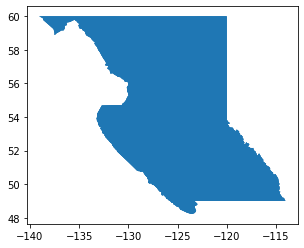

In [ ]:
## Load the municipal boundaries data
file_path = './' + province +  '/municipal_boundaries/ABMS_LAA_polygon.shp'
# counties = gpd.read_file(file_path).to_crs(4326)
counties.rename(columns={'AA_NAME':'GEONAME'}, inplace=True) # rename column
# counties = counties.to_crs(4326)
counties.plot()
# counties.head()

In [ ]:
counties.to_crs(4326)
counties.head(5)

,AA_ID,GEONAME,ABRVN,BDY_TYPE,AA_TYPE,AA_PARENT,CHNG_ORG,UPT_TYPE,UPT_DATE,MAP_STATUS,...,OC_M_YR,OC_M_TYPE,WBST_RL,IMAGE_URL,AFCTD_AREA,AREA_SQM,LENGTH_M,SHAPE,OBEJCTID,geometry
0,7,District of Houston,Houston,Legal,Municipality,Regional District of Bulkley-Nechako,MCSCD,E,None,Not Appended,...,1969,OIC,None,None,None,7.159461e+07,45041.6045,None,17287.0,"POLYGON ((-126.68323 54.42507, -126.68322 54.4..."
1,8,Town of Smithers,Smithers,Legal,Municipality,Regional District of Bulkley-Nechako,MCSCD,E,None,Not Appended,...,2003,OIC,None,None,None,1.585043e+07,37165.3551,None,17288.0,"POLYGON ((-127.18673 54.79748, -127.18673 54.7..."
2,9,The Corporation of the Village of Telkwa,Telkwa,Legal,Municipality,Regional District of Bulkley-Nechako,MCSCD,E,None,Not Appended,...,2003,OIC,None,None,None,6.805661e+06,23265.9658,None,17289.0,"POLYGON ((-127.08082 54.67393, -127.07633 54.6..."
3,10,District of Vanderhoof,Vanderhoof,Legal,Municipality,Regional District of Bulkley-Nechako,MCSCD,E,None,Not Appended,...,1982,OIC,None,None,None,5.939728e+07,83995.6322,None,17290.0,"POLYGON ((-124.34074 54.01635, -124.34072 54.0..."
4,11,RDBN Electoral Area A,RDBN - EA A,Legal,Electoral Area,Regional District of Bulkley-Nechako,MCSCD,E,20190830,Not Appended,...,1967,OIC,None,None,None,3.717631e+09,360973.1510,None,17291.0,"POLYGON ((-127.24597 55.00000, -127.00000 55.0..."


In [ ]:
i_file_path = './' + province + '/by_year_quarter/' + province + '-2021-Q4.shp'
i_data = gpd.read_file(i_file_path)
i_data.head(5)

,quadkey,avg_d_kbps,avg_u_kbps,avg_lat_ms,tests,devices,year,quarter,conn_type,PRUID,...,CDUID,CDNAME,DAUID,SACTYPE,DA_POP,PCUID,PCNAME,PCTYPE,PCCLASS,geometry
0,0201313131332332,11263,671,10,1,1,2021,Q4,fixed,59,...,5957,Stikine,59570200,5,75.0,None,None,None,None,"POLYGON ((4014038.387 3374415.862, 4014272.328..."
1,0210202023331122,20614,1839,622,1,1,2021,Q4,fixed,59,...,5957,Stikine,59570200,5,75.0,None,None,None,None,"POLYGON ((4035850.708 3337016.964, 4036087.879..."
2,0210202033321132,20541,1459,642,1,1,2021,Q4,fixed,59,...,5957,Stikine,59570219,5,NaN,None,None,None,None,"POLYGON ((4062991.754 3315843.727, 4063230.754..."
3,0210202033321211,220,113,25,5,2,2021,Q4,fixed,59,...,5957,Stikine,59570210,5,NaN,None,None,None,None,"POLYGON ((4062090.543 3316158.948, 4062329.515..."
4,0210202033332301,9041,2360,86,1,1,2021,Q4,fixed,59,...,5957,Stikine,59570210,5,NaN,None,None,None,None,"POLYGON ((4063007.601 3312403.290, 4063246.898..."


In [ ]:
aa = i_data.to_crs(4326)
print(aa['geometry'].head(5))

bb = counties.to_crs(4326)
print(bb['geometry'].head(5))

0    POLYGON ((-135.05493 59.71487, -135.04944 59.7...
1    POLYGON ((-134.31885 59.57051, -134.31335 59.5...
2    POLYGON ((-133.69263 59.57051, -133.68713 59.5...
3    POLYGON ((-133.70911 59.56772, -133.70361 59.5...
4    POLYGON ((-133.65417 59.54546, -133.64868 59.5...
Name: geometry, dtype: geometry
0    POLYGON ((-126.68323 54.42507, -126.68322 54.4...
1    POLYGON ((-127.18673 54.79748, -127.18673 54.7...
2    POLYGON ((-127.08082 54.67393, -127.07633 54.6...
3    POLYGON ((-124.34074 54.01635, -124.34072 54.0...
4    POLYGON ((-127.24597 55.00000, -127.00000 55.0...
Name: geometry, dtype: geometry


In [ ]:
##### Data prep stage ####

province_short = 'BC'
years = ['2019', '2020', '2021']
quarters = ['Q1', 'Q2', 'Q3', 'Q4']

i_yq_data = {} # placeholder for the geoDataFrames

for i, year in enumerate(years):
    for j, quarter in enumerate(quarters):
        
        yq = str(year) + '-' + str(quarter)
        print('processing {yq}'.format(yq=yq))
        
        i_file_path = './' + province + '/by_year_quarter/' + province + '-' + yq + '.shp'
        i_data = gpd.read_file(i_file_path)
        i_ab_data = i_data.to_crs(4326)

        i_joint_data = gpd.sjoin(i_ab_data, counties, how='inner', predicate='intersects') # bottleneck
        # Convert kbps --> Mbps for easier reading
        i_joint_data['avg_d_mbps'] = i_joint_data['avg_d_kbps']/1000
        i_joint_data['avg_u_mbps'] = i_joint_data['avg_u_kbps']/1000

        i_w_data = w_avg(i_joint_data, name_col='GEONAME', val_cols=['avg_d_mbps', 'avg_u_mbps', 'avg_lat_ms'], w_col='tests')

        i_county_data = counties[['GEONAME', 'geometry']].merge(i_w_data, on='GEONAME').to_crs(3401)
        
        labels1 = ["0 to 25 Mbps", "25 to 50 Mbps", "50 to 100 Mbps", "100 to 150 Mbps", "150 to 200 Mbps"]
        i_county_data['group1'] = pd.cut(i_county_data['avg_d_mbps'], (0, 25, 50, 100, 150, 200), right=False, labels = labels1)
        
        labels2 = ["<50 Mbps", ">=50 Mbps"]
        i_county_data['group2'] = pd.cut(i_county_data['avg_d_mbps'], (0, 50, 200), right=False, labels = labels2)

        i_yq_data[yq] = i_county_data
        

In [ ]:
out_path = './' + province + '/' + province_short + '_yq_data_by_municipalities.p'
with open(out_path, 'wb') as f:
    pickle.dump(i_yq_data, f)
print('save complete')

save complete


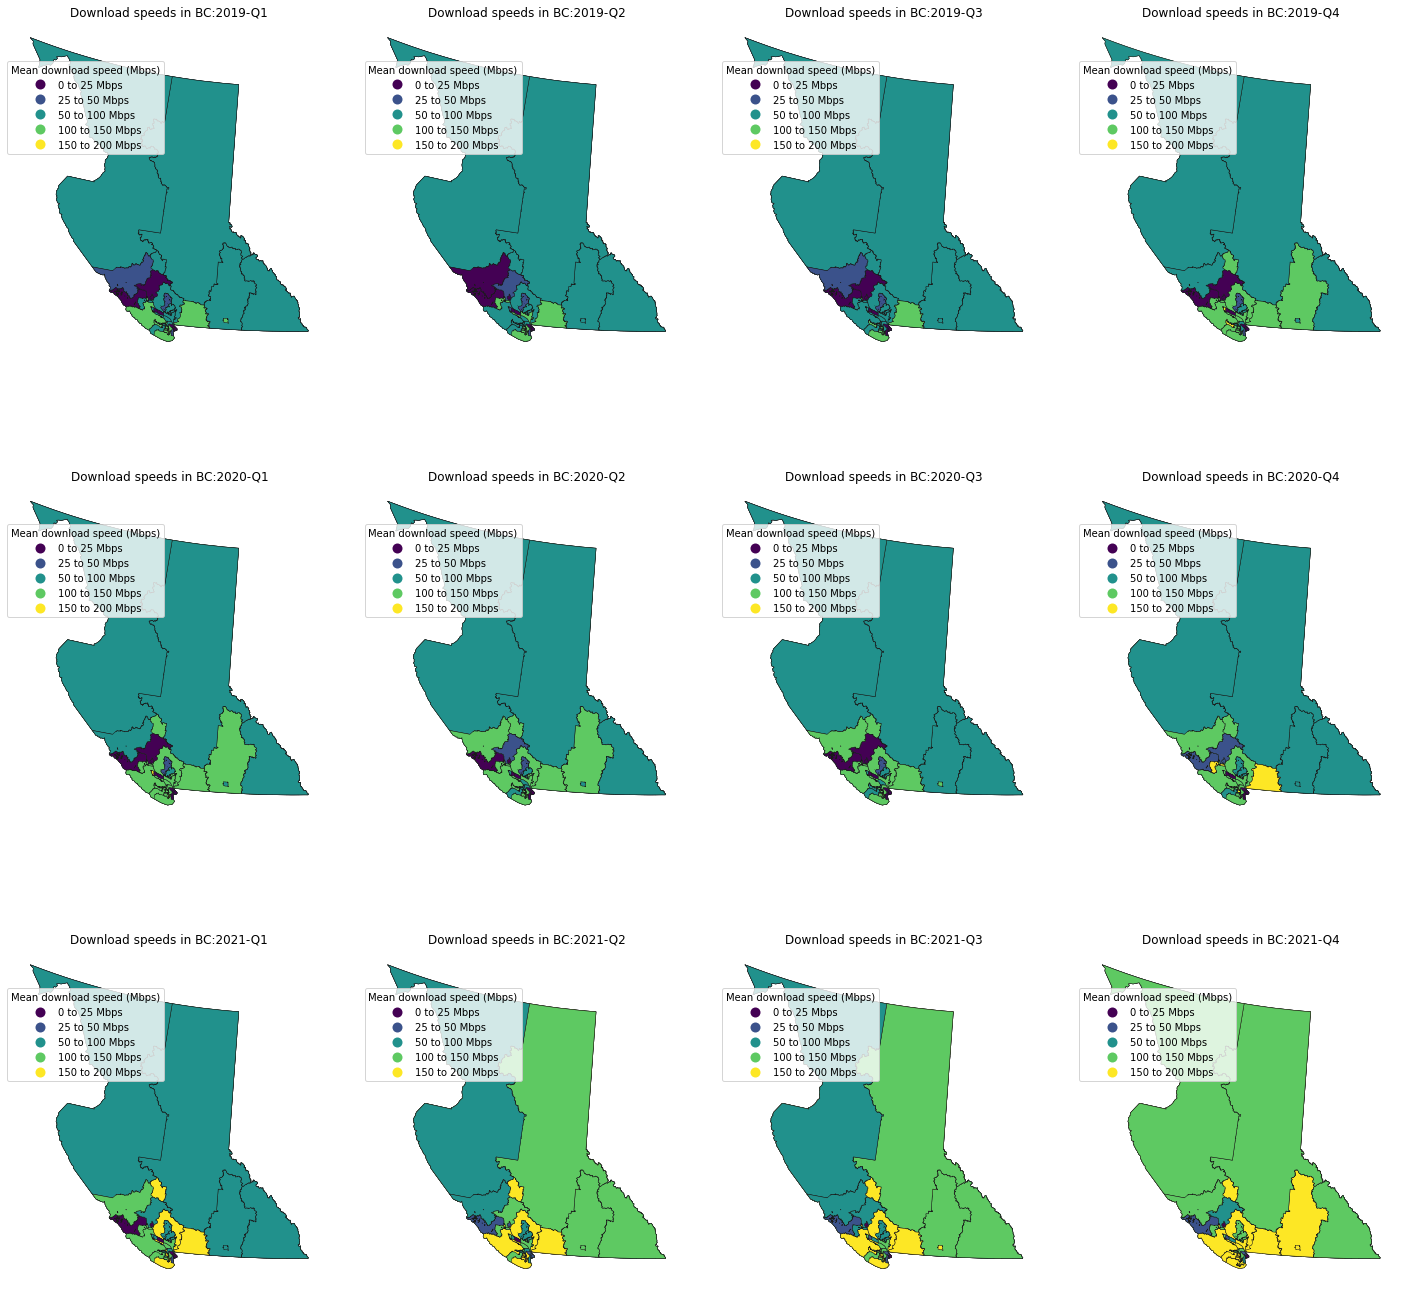

In [ ]:
#### Plotting stage: detailed map

fig, axs = plt.subplots(len(years),len(quarters), figsize = (20, 20))

for i, year in enumerate(years):
    for j, quarter in enumerate(quarters):
        df_name = str(year) + '-' + str(quarter)
        i_county_data = i_yq_data[df_name]
        i_ax = axs[i, j]
        i_county_data.plot(column='group1', cmap='viridis', linewidth=0.5, ax=i_ax, edgecolor='0.1', legend=True)
        i_ax.axis('off')
        fig_title = 'Download speeds in ' + province_short + ':' + df_name
        i_ax.set_title(fig_title)
        leg = i_ax.get_legend()
        leg.set_bbox_to_anchor((0.5, 0.9))
        leg.set_title('Mean download speed (Mbps)')
fig.tight_layout()
plt.show()


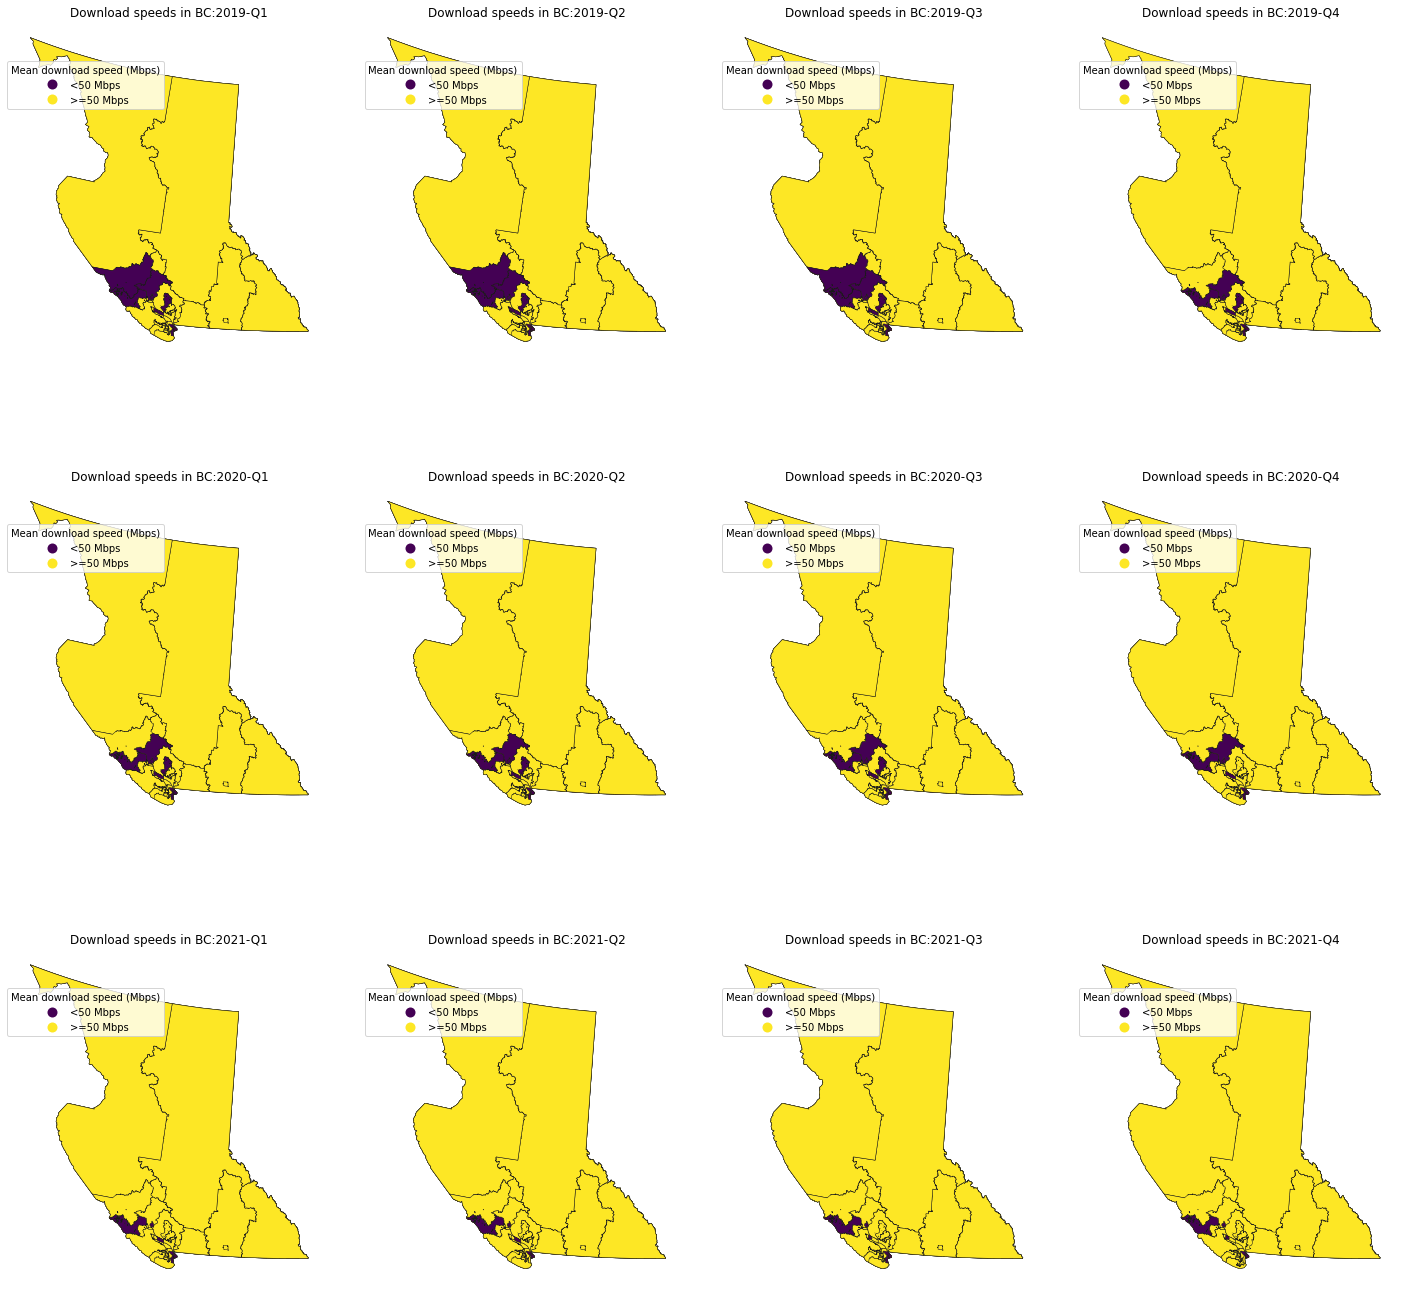

In [ ]:
#### Plotting stage: binary map

fig, axs = plt.subplots(len(years),len(quarters), figsize = (20, 20))

for i, year in enumerate(years):
    for j, quarter in enumerate(quarters):
        df_name = str(year) + '-' + str(quarter)
        i_county_data = i_yq_data[df_name]
        i_ax = axs[i, j]
        i_county_data.plot(column='group2', cmap='viridis', linewidth=0.5, ax=i_ax, edgecolor='0.1', legend=True)
        i_ax.axis('off')
        fig_title = 'Download speeds in ' + province_short + ':' + df_name
        i_ax.set_title(fig_title)
        leg = i_ax.get_legend()
        leg.set_bbox_to_anchor((0.5, 0.9))
        leg.set_title('Mean download speed (Mbps)')
fig.tight_layout()
plt.show()


In [ ]:
# what's next?
import pickle

with open('./British Columbia/BC_yq_data_by_municipalities.p', 'rb') as f:
  data = pickle.load(f)

In [ ]:
tt = data['2021-Q4']
print(tt.shape) # there are 369 municipalities 
# tt.head(10)
sub_tt = tt[tt['group2'] == '<50 Mbps'] 
print(sub_tt.shape) # there are 59 municipalities with download speed <50 mbps
sub_tt_sorted = sub_tt.sort_values('avg_d_mbps', ascending=True)
sub_tt_sorted


(369, 8)
(59, 8)


,GEONAME,geometry,avg_d_mbps,avg_u_mbps,avg_lat_ms,tests,group1,group2
209,CCRD Electoral Area B,"POLYGON ((-896488.463 5855988.053, -897232.069...",3.155000,3.505333,39.666667,6,0 to 25 Mbps,<50 Mbps
108,RDKS Electoral Area D,"POLYGON ((-1059664.826 6569701.783, -1055643.3...",4.837500,2.499917,513.916667,12,0 to 25 Mbps,<50 Mbps
95,RDFFG Electoral Area E,"POLYGON ((-500912.780 5962737.282, -488585.733...",7.074250,4.474000,40.500000,4,0 to 25 Mbps,<50 Mbps
309,Stikine Region (Unincorporated),"POLYGON ((-1194494.417 6848087.391, -1193306.9...",7.820800,1.132700,204.600000,10,0 to 25 Mbps,<50 Mbps
334,The Corporation of the Village of Zeballos,"POLYGON ((-847503.203 5603126.879, -847704.573...",8.731000,0.955000,149.000000,1,0 to 25 Mbps,<50 Mbps
208,CCRD Electoral Area A,"POLYGON ((-892139.861 5743871.070, -910156.810...",10.398333,0.724667,467.000000,3,0 to 25 Mbps,<50 Mbps
103,District of Stewart,"POLYGON ((-927462.808 6336381.685, -927637.258...",10.917562,9.628250,41.562500,32,0 to 25 Mbps,<50 Mbps
110,RDKS Electoral Area F,"POLYGON ((-800195.359 6621877.235, -823526.373...",12.582600,0.915000,27.200000,5,0 to 25 Mbps,<50 Mbps
8,RDBN Electoral Area E,"POLYGON ((-696582.025 6048932.110, -696565.498...",13.186412,4.055412,223.529412,17,0 to 25 Mbps,<50 Mbps
136,Village of Lytton,"POLYGON ((-468324.586 5581052.044, -468365.096...",13.721364,15.558227,22.681818,22,0 to 25 Mbps,<50 Mbps


In [ ]:
# data construction based on the quadkey.
# join all the tables by quadkey